# Attention Architecture

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import music21

In [3]:
from fastai.text import *
from transformer_xl.default_txl import get_default_model
from enum import Enum
import torch
from fastai.text.models.awd_lstm import *
from fastai.text.models.transformer import *

In [4]:
from fastai_data import *

In [5]:
import numpy as np
import torch.nn as nn

In [6]:
from ht_encode import *
import ht_encode

In [7]:
bs=8
bptt=24

In [8]:
import fastai_data
fastai_data.Y_OFFSET=1

In [9]:
path = Path('data/midi/v7/midi_encode/np/hook_noinv/')
ht_encode.config.continuous=False
data = LMNPDataBunch.load(path, bs=bs, bptt=bptt, cache_name='tmp/sample')
# data = LMNPDataBunch.load(path, bs=bs, bptt=bptt, cache_name='tmp/all')

In [11]:
ob = data.one_batch(); ob[0].shape

torch.Size([8, 24, 16, 11])

In [12]:
ob[0][0,0]

tensor([[ 3,  4, 10,  9,  3, 10, 14,  5,  0,  3,  3],
        [ 3,  4, 10,  9,  4, 10, 14,  5,  0,  4,  3],
        [ 3,  4, 12,  9,  3, 10, 14,  5,  0,  4,  3],
        [ 3,  4, 12,  9,  4, 10, 14,  5,  0,  4,  3],
        [ 4,  4,  5,  9,  3, 10, 14,  5,  0,  4,  3],
        [ 4,  4,  5,  9,  4, 10, 14,  5,  0,  4,  3],
        [ 4,  4,  3,  9,  3, 10, 14,  5,  0,  4,  3],
        [ 4,  4,  3,  9,  4, 10, 14,  5,  0,  4,  3],
        [ 5,  4,  7,  9,  3,  3,  7, 10,  0,  3,  3],
        [ 5,  4,  7,  9,  4,  3,  7, 10,  0,  4,  3],
        [ 5,  4,  7,  9,  4,  3,  7, 10,  0,  4,  3],
        [ 5,  4,  7,  9,  4,  3,  7, 10,  0,  4,  3],
        [ 6,  4, 12,  8,  3,  3,  7, 10,  0,  4,  3],
        [ 6,  4, 12,  8,  4,  3,  7, 10,  0,  4,  3],
        [ 6,  4,  3,  9,  3,  3,  7, 10,  0,  4,  3],
        [ 6,  4,  3,  9,  4,  3,  7, 10,  0,  4,  3]])

In [13]:
config = tfmerXL_lm_config

In [14]:
PAD_IDX=ht_encode.config.pad_idx+ht_encode.config.enc_offset

In [28]:
train_ids_file = path/'tmp/all/train_ids.npy'
all_ids = np.load(train_ids_file)
id_cat = np.concatenate(all_ids); id_cat.shape
ax = tuple(range(len(id_cat.shape)-1))
max_vocab = id_cat.max(axis=ax)
max_vocab = (max_vocab+1).tolist(); max_vocab

[7, 12, 15, 13, 5, 15, 15, 15, 15, 5, 7]

In [18]:

# ENC_IDXS = [0,1,2,3,4,5,6,7,8,9,10]
# iB,iM,iN,iNO,iND,iC1,iC2,iC3,iC4,iCD,iCI = ENC_IDXS
# CIDXS = [iC1,iC2,iC3,iC4]
# CIDX_ALL = CIDXS + [iCD,iCI]
# NIDX_ALL = [iN,iNO,iND]
# BIDX_ALL = [iB,iM]

In [51]:
list(zip([0,1,2,3,4,5],[0,1,2,3,4,5]))

[(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5)]

In [71]:
EMB_IDXS = [0,1,2,3,4,5]
EMB_DIM = [100,100,100,100,100,100]
VOCAB_SZ = [max_vocab[i] for i in [iN,iNO,iND,iCI,iB,iM]]
EMB_MAP = list(zip(EMB_IDXS,VOCAB_SZ,EMB_DIM))
eN,eO,eD,eI,eB,eM = EMB_MAP

In [72]:
idx2embidx = {
    iN:eN,iNO:eO,iND:eD,
    iC1:eN,iC2:eN,iC3:eN,iC4:eN,iCD:eD,iCI:eI,
    iB:eB,
    iM:eM
}

In [73]:
EMB_MAP

[(0, 15, 100),
 (1, 13, 100),
 (2, 5, 100),
 (3, 7, 100),
 (4, 7, 100),
 (5, 12, 100)]

In [74]:
config['emb_map'] = EMB_MAP
config['idx_map'] = idx2embidx

In [107]:
total_embs = sum([v[1] for k,v in idx2dims.items() if k not in [iB,iM]])
config['d_model'] = total_embs

In [108]:
config['ctx_len'] = 0
config['mem_len'] = 256
config['d_inner'] = 1024

In [123]:
embed = TransformerEmbed(**config)

In [124]:
out = embed(ob[0]); out.shape

torch.Size([8, 24, 100, 16, 9])

In [125]:
EMB_MAP

[(0, 15, 100),
 (1, 13, 100),
 (2, 5, 100),
 (3, 7, 100),
 (4, 7, 100),
 (5, 12, 100)]

In [126]:
out[...,None].shape

torch.Size([8, 24, 100, 16, 9, 1])

In [127]:
# config

In [128]:
# test = PositionalEncoding(100)
# pos = torch.arange(50, -1, -1, dtype=torch.float)
# test(pos).shape
# test(pos)[0]

In [122]:
class TransformerEmbed(nn.Module):
    def __init__(self, emb_map, idx_map, embed_p:float=0.1, **kwargs):
        super().__init__()
        # note, octave, duration, instrument
        self.idx_map = idx_map
        self.emb_map = emb_map
        embeddings = []
        for idx,in_d,out_d in emb_map:
            embeddings.append(nn.Embedding(in_d, out_d, padding_idx=PAD_IDX))
        self.embeddings = nn.ModuleList(embeddings)
        self.drop_emb = nn.Dropout(embed_p)
        
    def forward(self, x):
        # batch x bptt x (n,o,d,i)
        pos_enc = self.embeddings[eB[0]](x[...,iB]) + self.embeddings[eM[0]](x[...,iM])
        embs = []
        for i in range(x.shape[-1]):
            emb_idx = self.idx_map[i][0]
            if i in [iB,iM]: continue
            embx = self.embeddings[emb_idx](x[...,i])
            embs.append(embx + pos_enc)
        emb = torch.stack(embs, dim=-1)
        emb = emb.permute(0,1,3,2,4)
        return self.drop_emb(emb)

In [ ]:
class DownConv(nn.Module):
    def __init__(self, d_model):
        pass

In [12]:
class TXLLinearDecoder(nn.Module):
    "To go on top of a RNNCore module and create a Language Model."
    initrange=0.1

    def __init__(self, n_out:int, n_hid:int, tie_encoder:nn.Module=None, bias:bool=True):
        super().__init__()
        self.decoder = nn.Linear(n_hid, n_out, bias=bias)
        self.decoder.weight.data.uniform_(-self.initrange, self.initrange)
        if bias: self.decoder.bias.data.zero_()
        if tie_encoder: self.decoder.weight = tie_encoder.weight

    def forward(self, input):
        return self.decoder(input)

In [13]:
class TransformerDec(nn.Module):
    def __init__(self, txl_emb, idx_map, output_p=0.0, out_bias=True, **kwargs):
        super().__init__()
        self.output_dp = RNNDropout(output_p)
        
        start_range = 0
        self.ranges = []
        decoders = []
        for k,v in idx_map.items():
            if k in iB,iM: continue
            emb = txl_emb.embeddings[v[0]]
            decoder = TXLLinearDecoder(emb.num_embeddings, emb.embedding_dim, tie_encoder=emb, bias=out_bias)
            decoders.append(decoder)
            end_range = start_range+emb.embedding_dim
            self.ranges.append([start_range, end_range])
            start_range = end_range
            
        self.decoders = nn.ModuleList(decoders)
        
    def forward(self, input):
        raw_outputs, outputs = input
        output = self.output_dp(outputs[-1])
        res = []
        for dec,(start,end) in zip(self.decoders, self.ranges):
            res.append(dec(output[...,start:end]))
        return res, raw_outputs, outputs

In [14]:

class LMNPTransformerXL(nn.Module):
    "TransformerXL model: https://arxiv.org/abs/1901.02860."
    def __init__(self, encoder, ctx_len:int, n_layers:int, n_heads:int, d_model:int, d_head:int, d_inner:int, 
                 resid_p:float=0., attn_p:float=0., ff_p:float=0., embed_p:float=0., bias:bool=False, scale:bool=True,
                 act:Activation=Activation.ReLU, double_drop:bool=True, attn_cls:Callable=MultiHeadRelativeAttention,
                 learned_pos_enc:bool=False, mask:bool=True, mem_len:int=0, **kwargs):
        super().__init__()
        self.encoder = encoder
        self.pos_enc = nn.Embedding(ctx_len, d_model) if learned_pos_enc else PositionalEncoding(d_model)
        self.u = nn.Parameter(torch.Tensor(n_heads, 1, d_head)) #Remove 1 for einsum implementation of attention
        self.v = nn.Parameter(torch.Tensor(n_heads, 1, d_head)) #Remove 1 for einsum implementation of attention
        self.mem_len,self.n_layers,self.d_model,self.mask = mem_len,n_layers,d_model,mask
        if self.mem_len > 0: self.reset()
        self.layers = nn.ModuleList([DecoderLayer(n_heads, d_model, d_head, d_inner, resid_p=resid_p, attn_p=attn_p,
                      ff_p=ff_p, bias=bias, scale=scale, act=act, double_drop=double_drop, 
                      attn_cls=attn_cls) for k in range(n_layers)])
    
    def reset(self):
        "Reset the internal memory."
        self.hidden = [next(self.parameters()).data.new(0) for i in range(self.n_layers+1)]
#         self.hidden = [next(self.parameters()).data.new(0).cuda() for i in range(self.n_layers+1)]

    def _update_mems(self, hids):
        if not getattr(self, 'hidden', False): return None
        assert len(hids) == len(self.hidden), 'len(hids) != len(self.hidden)'
        with torch.no_grad():
            for i in range(len(hids)):
                cat = torch.cat([self.hidden[i], hids[i]], dim=1)
                self.hidden[i] = cat[:,-self.mem_len:].detach()
    
    def select_hidden(self, idxs): self.hidden = [h[idxs] for h in self.hidden]
    
    def forward(self, x):
        bs,x_len,_ = x.size()
        inp = self.encoder(x)
        m_len = self.hidden[0].size(1) if hasattr(self, 'hidden') and len(self.hidden[0].size()) > 1 else 0
        seq_len = m_len + x_len
        mask = torch.triu(x.new_ones(x_len, seq_len), diagonal=1+m_len).byte()[None,None] if self.mask else None
        #[None,:,:None] for einsum implementation of attention
        hids = []
        pos = torch.arange(seq_len-1, -1, -1, device=inp.device, dtype=inp.dtype)
        pos_enc = self.pos_enc(pos)
        hids.append(inp)
        for i, layer in enumerate(self.layers):
            mem = self.hidden[i] if self.mem_len > 0 else None
            inp = layer(inp, r=pos_enc, u=self.u, v=self.v, mask=mask, mem=mem)
            hids.append(inp)
        core_out = inp[:,-x_len:]
        if self.mem_len > 0 : self._update_mems(hids)
        return (self.hidden if self.mem_len > 0 else [core_out]),[core_out]

In [27]:
def get_language_model(config:dict=None, drop_mult:float=1.):
    "Create a language model from `arch` and its `config`, maybe `pretrained`."
    for k in config.keys(): 
        if k.endswith('_p'): config[k] *= drop_mult
    init = config.pop('init') if 'init' in config else None
    
    embed = TransformerEmbed(**config)
    txl = LMNPTransformerXL(embed, **config)
    decoder = TransformerDec(embed, **config)
    model = SequentialRNN(txl, decoder).cuda()
    
    return model if init is None else model.apply(init)


def language_model_learner(data:DataBunch, config:dict=None, drop_mult:float=1., pretrained:bool=True,
                           **learn_kwargs) -> 'LanguageLearner':
    "Create a `Learner` with a language model from `data` and `arch`."
    model = get_language_model(config=config, drop_mult=drop_mult)
    learn = LanguageLearner(data, model, split_func=tfmer_lm_split, **learn_kwargs)
    return learn

In [28]:

class LMNPLoss(nn.Module):
    "Same as `func`, but flattens input and target."
    def __init__(self):
        super().__init__()
        self.fn = nn.CrossEntropyLoss(ignore_index=PAD_IDX) 
        # not using func otherwise _loss_func_name2activ uses this attribute to get cross entropy loss

    def __repr__(self): return f"numpyenc loss of {self.fn}"

    def forward(self, inputs:Tensor, target:Tensor, **kwargs)->Rank0Tensor:
        losses = []
        for idx,input in enumerate(inputs):
            if idx in BIDX_ALL: continue
            t = target[:,:,idx]
            input = input.view(-1,input.shape[-1])
            losses.append(self.fn(input, t.view(-1)))
        return sum(losses)

In [29]:
import pdb

In [30]:
def lmnp_accuracy(inputs:Tensor, target:Tensor)->Rank0Tensor:
    "Compute accuracy with `targs` when `input` is bs * n_classes."
    inputs = [i.argmax(dim=-1).unsqueeze(dim=-1) for i in inputs]
    input_cat = torch.cat(inputs, dim=-1).cpu().numpy()
    target = target.cpu().numpy()
    acc = (input_cat==target).astype(float)
    acc[target==PAD_IDX] = np.nan
    acc[:,:,BIDX_ALL] = np.nan
#     print(np.nanmean(acc))
#     pdb.set_trace()
    return torch.tensor(np.nanmean(acc))

In [31]:
learn = language_model_learner(data, config, clip=0.25, loss_func=LMNPLoss(), metrics=[lmnp_accuracy])

In [32]:
learn.validate()

[25.646095, tensor(0.5148)]

In [33]:
# x,y = data.one_batch(cpu=False)
# # emb = learn.model[0]
# # a = torch.ones_like(x)
# # emb.encoder(x)

# out = x[0].cpu().numpy()
# song = dec_arr(out)
# song.to_stream().show()

In [34]:
# learn.model.cuda()
# learn.model[0].reset()
# out = learn.model(x)

In [35]:
# # clip = 0.5
# learn.lr_find(num_it=300)
# learn.recorder.plot()

In [36]:
learn.fit_one_cycle(1, 4e-4)

epoch,train_loss,valid_loss,lmnp_accuracy
1,7.592477,7.517922,0.826093


In [37]:
learn.save('first_run')

In [38]:
from fastai import basic_train

In [39]:
def predict_func(parts): return [F.softmax(p, dim=-1) for p in parts]

In [40]:
loss_func_name = camel2snake(learn.loss_func.__class__.__name__)
basic_train.loss_func_name2activ[loss_func_name] = predict_func
basic_train._loss_func2activ(learn.loss_func)

<function __main__.predict_func(parts)>

In [41]:
def predict(self, xb, n_words:int=1, no_unk:bool=True, temperature:float=1., min_p:float=None, sep:str=' ',
            decoder=decode_spec_tokens):
    "Return the `n_words` that come after `text`."
    ds = self.data.single_dl.dataset
    self.model.reset()
    if xb.shape[0] > 1: xb = xb[0][None]
    yb = torch.ones_like(xb)
    new_idx = []
    for _ in range(n_words): #progress_bar(range(n_words), leave=False):
        timestep = []
        outputs = learn.pred_batch(batch=(xb,yb))
        for item in outputs: #progress_bar(range(n_words), leave=False):
            res = item[0][-1]
            if min_p is not None: 
                if (res >= min_p).float().sum() == 0:
                    warn(f"There is no item with probability >= {min_p}, try a lower value.")
                else: res[res < min_p] = 0.
            if temperature != 1.: res.pow_(1 / temperature)
            idx = torch.multinomial(res, 1).item()
            timestep.append(idx)
        new_idx.append(timestep)
        xb = xb.new_tensor(timestep).view(1,1,-1)
    return new_idx


In [42]:
xb,yb = learn.data.one_batch(cpu=False)

In [43]:
out = predict(learn, xb, n_words=60)

In [44]:
min(np.array(out)[:,iNO])

6

In [45]:
np.array(out)[:,iNO]

array([ 9, 10,  9,  9, ...,  9, 10,  9, 10])

In [46]:
song = dec_arr(np.array(out)); song

Part[0]:
[Chords]:
B(abs=7.0:dur=4.0) C([[sd=1:oct=0, sd=2#:oct=0, sd=1:oct=1, sd=6:oct=1]])
B(abs=12.0:dur=0.75) C([[sd=5:oct=0, sd=6:oct=0, sd=3:oct=1, sd=1:oct=2]])
B(abs=12.75:dur=0.75) C([[sd=7:oct=0, sd=3:oct=1, sd=2:oct=2, sd=1:oct=3]])
B(abs=13.5:dur=0.75) C([[sd=1:oct=0, sd=2:oct=0, sd=5:oct=0, sd=4:oct=1]])
B(abs=14.5:dur=1.0) C([[sd=1:oct=0, sd=3:oct=0, sd=5:oct=0, sd=7:oct=0]])

[Notes]:
B(abs=0.0:dur=0.5) P(sd=3:oct=6)
B(abs=0.5:dur=0.25) P(sd=3:oct=6)
B(abs=0.75:dur=0.25) P(sd=2:oct=6)
B(abs=1.0:dur=0.25) P(sd=3:oct=6)
B(abs=1.25:dur=0.25) P(sd=3:oct=6)
B(abs=1.5:dur=0.25) P(sd=3:oct=6)
B(abs=1.75:dur=0.25) P(sd=3:oct=6)
B(abs=2.0:dur=0.5) P(sd=5:oct=6)
B(abs=2.5:dur=0.25) P(sd=3:oct=6)
B(abs=2.75:dur=0.25) P(sd=1:oct=6)
B(abs=3.0:dur=0.25) P(sd=3:oct=6)
B(abs=3.25:dur=0.25) P(sd=6#:oct=6)
B(abs=3.5:dur=0.25) P(sd=6:oct=6)
B(abs=3.75:dur=0.25) P(sd=1:oct=5)
B(abs=4.0:dur=0.5) P(sd=2:oct=5)
B(abs=4.25:dur=0.25) P(sd=1:oct=3)
B(abs=4.5:dur=0.25) P(sd=1:oct=5)
B(abs=4.75:dur

In [47]:
stream = song.to_stream()

In [48]:
stream.show('text')

{0.0} <music21.instrument.Piano Piano>
{0.0} <music21.stream.Part 0x7fabed00b898>
    {0.0} <music21.stream.Part 0x7fabed00b7f0>
        {0.0} <music21.note.Note E>
        {0.5} <music21.note.Note E>
        {0.75} <music21.note.Note D>
        {1.0} <music21.note.Note E>
        {1.25} <music21.note.Note E>
        {1.5} <music21.note.Note E>
        {1.75} <music21.note.Note E>
        {2.0} <music21.note.Note G>
        {2.5} <music21.note.Note E>
        {2.75} <music21.note.Note C>
        {3.0} <music21.note.Note E>
        {3.25} <music21.note.Note B->
        {3.5} <music21.note.Note A>
        {3.75} <music21.note.Note C>
        {4.0} <music21.note.Note D>
        {4.25} <music21.note.Note C>
        {4.5} <music21.note.Note C>
        {4.75} <music21.note.Note E>
        {5.0} <music21.note.Note C>
        {5.25} <music21.note.Note C>
        {5.5} <music21.note.Note C>
        {5.75} <music21.note.Note C>
        {6.0} <music21.note.Note D>
        {6.25} <music21.note.Not

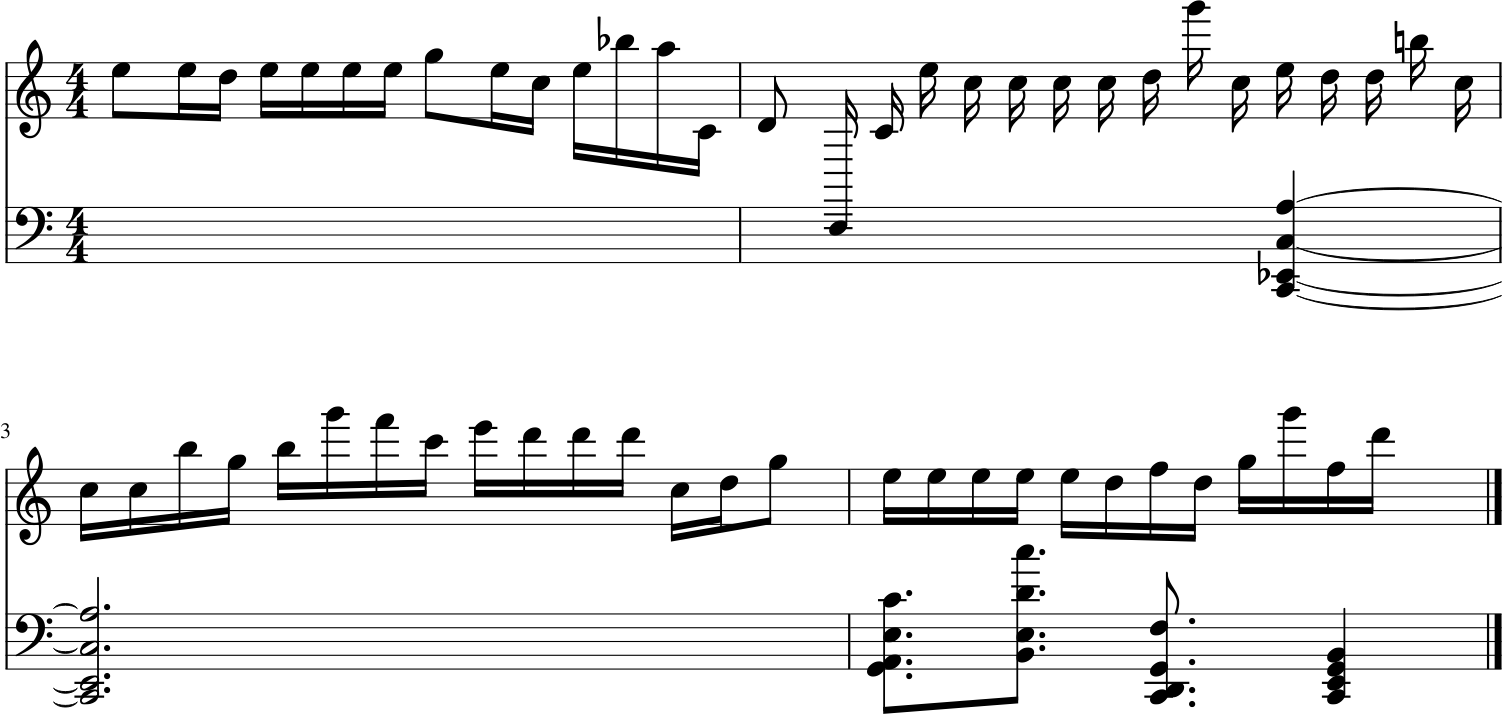

In [49]:
stream.show()

In [50]:
stream.show('midi')